This notebook shows the implementation of H(div) mixed-FEM on general quadlirateral as given in Arbogast and Correa's 2016 paper: Two families of H(div) mixed finite elements on quadrilaterals of minimal dimension

In [1]:
using Plots
using LinearAlgebra
using Jacobi
using Test
using SparseArrays
using Random

# MMS

We consider following functions as our exact solution

$$ p(x,y,z) = x(1-x)y(1-y)$$
$$ \nabla p = \begin{bmatrix}
(1-2x)y(1-y) \\
x(1-x)(1-2y) 
\end{bmatrix} $$

For now we consider $\boldsymbol{k} = \boldsymbol{I} $, so velocity and forcing functions are
$\boldsymbol{v} = -\nabla p, \quad f = \nabla \cdot \boldsymbol{v} $. 

We solve the following weak form, find $(\boldsymbol{u}, p) \in \textbf{V}\times\text{Q}$ such that
$$
(\boldsymbol{k}^{-1} \boldsymbol{u}, \boldsymbol{v} ) - (p,\nabla\cdot\boldsymbol{v}) = -<g,\boldsymbol{v}\cdot{n} >, \quad \boldsymbol{v} \in \textbf{V}
$$
$$
(q, \nabla\cdot\boldsymbol{u}) = (q,f), \quad q \in \text{Q}
$$

In [2]:
function Perm(x, y)
    k = [1. 0.;0. 1.]
    return k
end

function PressureQuartic(x, y)

    p = @. 3.14 + x*(1-x)*y*(1-y)

    return p
end

function VelocityQuartic(x, y)

    m = length(x)
    k = Perm(x, y)
    vx = @. -(k[1,1]*(1-2*x)*y*(1-y) + k[1,2]*(1-2*y)*x*(1-x))
    vy = @. -(k[2,1]*(1-2*x)*y*(1-y) + k[2,2]*(1-2*y)*x*(1-x))
    v = zeros(2,m)
    v[1,:] = vx
    v[2,:] = vy

    return v
end

function ForcingQuartic(x, y)

    k = Perm(x, y)
    vx_x = @. -(k[1,1]*(-2)*y*(1-y) + k[1,2]*(1-2*y)*(1-2*x))
    vy_y = @. -(k[2,1]*(1-2*y)*(1-2*x) + k[2,2]*(-2)*x*(1-x))
    f = vx_x + vy_y
    return f
end

ForcingQuartic (generic function with 1 method)

In [3]:
function BilinearMap(Coord_E, xhat, yhat)
    """ 
    This function maps [xhat,yhat] in Ehat=[-1,1]^2 
    to (x,y) in quadrilateral E.
    Input:
    ------
    coord_E: coordinates of quadrilateral E .
    coord_E is 4x2 array
    coord_E = [x1 y1;x2 y2;x3 y3;x4 y4] with vertices numbering
    3----4
    |    |
    1----2
    [xhat, yhat] in Ehat
    Output:
    ------
    x, y: mapped vector in E.
    DF_E: Jacobian matrix
    J_E: det(DF_E)
    """
    m = length(xhat)
    N1 = @. 0.25*(1-xhat)*(1-yhat)
    N2 = @. 0.25*(1+xhat)*(1-yhat)
    N3 = @. 0.25*(1-xhat)*(1+yhat)
    N4 = @. 0.25*(1+xhat)*(1+yhat)
    N = [N1 N2 N3 N4]
    X = N * Coord_E
    # X(2,m), 1st row x, 2nd row y,
    X = X'
    # gradient of N, [dN/dxhat; dN/dyhat]
    GradN = zeros(2,m,4)
    GradN[1,:,:] = @. 0.25*[-(1-yhat) (1-yhat) -(1+yhat) (1+yhat)]
    GradN[2,:,:] = @. 0.25*[-(1-xhat) -(1+xhat) (1-xhat) (1+xhat)]

    # JT = [[dx/dxhat, dy/dxhat],
    #       [dx/dyhat, dy/dyhat]] (3m x 3)

    JTxhat = GradN[1,:,:] * Coord_E
    dxdxhat = JTxhat[:,1]
    dydxhat = JTxhat[:,2]
    JTyhat = GradN[2,:,:] * Coord_E
    dxdyhat = JTyhat[:,1]
    dydyhat = JTyhat[:,2]

    # compute det
    detJ = @. dxdxhat*dydyhat - dydxhat*dxdyhat
    
    J = zeros(2,m,2)
    J[1,:,:] = [dxdxhat dxdyhat]
    J[2,:,:] = [dydxhat dydyhat]
    
    return X, J, detJ
end

BilinearMap (generic function with 1 method)

In [4]:
function GetNormal(Coord_E, xhat, yhat)
    """
    Input:
    ------
    coord_E: vertices coordinate of element E
    (xhat,yhat): coordinate of the edge in element Ehat=[-1,1]^2

    Output:
    -------
    n: computed normal of an edge of element E
    """

    X, J, detJ = BilinearMap(Coord_E, xhat, yhat)
    
    dxdxhat = J[1,:,1]
    dydxhat = J[2,:,1]
    
    dxdyhat = J[1,:,2]
    dydyhat = J[2,:,2]
    m = length(xhat)
    
    if (xhat == -ones(m) && -ones(m) < yhat < ones(m))
        # left edge, (0,0,1)x(dxdyhat,dydyhat,0)
        n1 = @. -dydyhat
        n2 = @. dxdyhat
        leng = @. sqrt(n1*n1 + n2*n2)
        n = zeros(2,m)
        n[1,:] = n1 ./ leng
        n[2,:] = n2 ./ leng

    elseif (xhat == ones(m) && -ones(m) < yhat < ones(m))
        # right edge, (0,0,-1)x(dxdyhat,dydyhat,0)
        n1 = @. dydyhat
        n2 = @. -dxdyhat
        leng = @. sqrt(n1*n1 + n2*n2)
        n = zeros(2,m)
        n[1,:] = n1 ./ leng
        n[2,:] = n2 ./ leng

    elseif (yhat == -ones(m) && -ones(m) < xhat < ones(m))
        # bottom edge, (0,0,-1)x(dxdxhat,dydxhat,0)
        n1 = @. dydxhat
        n2 = @. -dxdxhat
        leng = @. sqrt(n1*n1 + n2*n2)
        n = zeros(2,m)
        n[1,:] = n1 ./ leng
        n[2,:] = n2 ./ leng

    elseif (yhat == ones(m) && -ones(m) < xhat < ones(m))
        # top edge, (0,0,1)x(dxdxhat,dydxhat,0)
        n1 = @. -dydxhat
        n2 = @. dxdxhat
        leng = @. sqrt(n1*n1 + n2*n2)
        n = zeros(2,m)
        n[1,:] = n1 ./ leng
        n[2,:] = n2 ./ leng
    else
        error("edge is not defined")
    end

    return n, leng
end

GetNormal (generic function with 1 method)

In [5]:
function PrimeBasis(Coord_E, xhat, yhat)

    """
    Input:
    coord_E: coordinate of physical element E as a 4x2 matrix
    xhat, yhat: are defined on the reference element Ehat
    and should be given as a vector (xhat=[1] or xhat =[1;1],...)
    
    Return:
    Prime basis: of size (2,m,8) evaluated on xhat,yhat
    Note the first entries "2", are prime basis in the directions x,y
    "m" are the length of xhat,yhat, zhat
    "8" is the dimension of the prime basis
    """
    m = length(xhat)
    # supplements
    shat1 = [(1 .- xhat.^2) (2*xhat .* yhat)]
    shat2 = [(-2*xhat .* yhat) (yhat.^2 .- 1)]

    # X are in E
    X, J, detJ = BilinearMap(Coord_E, xhat, yhat)
    x = X[1,:]
    y = X[2,:]
    
    # we have 8 basis
    # the first 6 is defined on E using x,y
    P = zeros(2,m,8)
    P[1,:,1] = ones(m)
    P[1,:,2] = x
    P[1,:,3] = y
    P[2,:,4] = ones(m)
    P[2,:,5] = x
    P[2,:,6] = y
    
    # supplement are mapped to E by Piola
    P[1,:,7] = (J[1,:,1] .* shat1[:,1] + J[1,:,2] .* shat1[:,2]) ./ detJ
    P[2,:,7] = (J[2,:,1] .* shat1[:,1] + J[2,:,2] .* shat1[:,2]) ./ detJ

    P[1,:,8] = (J[1,:,1] .* shat2[:,1] + J[1,:,2] .* shat2[:,2]) ./ detJ
    P[2,:,8] = (J[2,:,1] .* shat2[:,1] + J[2,:,2] .* shat2[:,2]) ./ detJ
    
    return P
end

function VondermondeMat(Coord_E)
    """
    Input:
    ------
    coord_E: is the coordinate of vertices of element.
    Note
    3---4
    |   |
    1---2
    Output:
    ------
    VM: the 8x8 vondermonde matrix
    """
    nl, leng = GetNormal(Coord_E, [-1.], [0.])
    nr, leng = GetNormal(Coord_E, [1.], [0.])
    nb, leng = GetNormal(Coord_E, [0.], [-1.])
    nt, leng = GetNormal(Coord_E, [0.], [1.])
    normals = [nb nb nr nr nl nl nt nt]
    node1 = [-1.;-1.]
    node2 = [1.;-1.]
    node3 = [-1.;1.]
    node4 = [1.;1.]
    nodes = [node1 node2 node2 node4 node1 node3 node3 node4]
    # vondermonde matrix, V_ij = phi_j(x_i).n_i
    VM = zeros(8,8)
    for i=1:8
        for j=1:8
            P = PrimeBasis(Coord_E, nodes[1,i], nodes[2,i])
            VM[i,j] = P[1,1,j]*normals[1,i] + P[2,1,j]*normals[2,i]
        end
    end

    return VM
end

function GetNodalBasis(Coord_E, xhat, yhat)
    """This function returns the AC Nodal basis at point Xhat=[xhat,yhat]
    Input:
    ------
    coord_E: coordinate of element E as 4x2 array
    xhat, yhat: is the coordinate at reference element [-1,1]^2

    Output:
    -------
    Nhat: the nodal basis computed at Xhat=[xhat,yhat]
    shape (2,8) as
    Nhat = [v1,v2,v3,v4,v5,v6,v7,v8]
    local numbering is as follow 
     v7     v8
    3---------4
  v6|         |v4
    |         |
  v5|         |v3
    1---------2
     v1     v2
    """
    VM = VondermondeMat(Coord_E)
    P = PrimeBasis(Coord_E, xhat, yhat)
    invVM = inv(VM)
    invVM = inv(VM)
    
    m = length(xhat)
    Nhat = zeros(2,m,8)
    Nhat[1,:,:] = P[1,:,:] * invVM
    Nhat[2,:,:] = P[2,:,:] * invVM
    
    return Nhat
end

function GetDivNodalBasis(Coord_E)
    """This function returns the divergence of AC Nodal basis at point Xhat=[xhat,yhat]
    Input:
    ------
    coord_E: coordinate of element E as 4x2 array

    Output:
    -------
    Dhat: the divergence of nodal basis computed at Xhat=[xhat,yhat]
    shape (1,8)
    """
    VM = VondermondeMat(Coord_E)
    # This is the divergence of prime basis
    divV = [0. 1. 0. 0. 0. 1. 0. 0.]
    invVM = inv(VM)
    Dhat = divV * invVM

    return Dhat
end

GetDivNodalBasis (generic function with 1 method)

In [6]:
function GetConnectivity(nelx, nely)
    """This function returns the connectivity array based on edge
    ----6--------7----
    |       |        |
    3       4        5        
    |       |        |
    ----1--------2----

    2-------5--------6
    |       |        |
    |       |        |
    |       |        |
    1-------2--------3
    local numbering of one element is
    ----4----
    |       |
    3       2
    |       |
    ----1----

    3-------4
    |       |
    |       |
    |       |
    1-------2


    Input:
    ------
    nelx: number of element in x direction start from 1 NOT 0
    nely: number of element in y direction start from 1 NOT 0
    Output:
    ------
    IENe: connectivity array of size 4x(nelx*nely) based on edge numbering
    We need IENe for assembly
    IENn: connectivity array of size 4x(nelx*nely) based on node numbering
    We need IENn for find the coordinate of nodes in assembly
    """
    # number of element
    numelem = nelx*nely
    # number of nodes in x-direction
    nodex = nelx + 1
    # number of nodes in y-direction
    nodey = nely + 1
    IENe = zeros(Int64,4,numelem)
    for j=1:nely
        for i=1:nelx
            ele = (j-1)*nelx + i         
            IENe[1,ele] = i + (j-1)*(nodex+nelx)
            IENe[2,ele] = i + (j-1)*(nodex+nelx) + nodex
            IENe[3,ele] = i + (j-1)*(nodex+nelx) + nelx
            IENe[4,ele] = i + (j-1)*(nodex+nelx) + (nodex+nelx)
        end
    end

    IENn = zeros(Int64,4,numelem)
    for j=1:nely
        for i=1:nelx
            ele = (j-1)*nelx + i
            IENn[1,ele] = i + (j-1)*nodex
            IENn[2,ele] = i + (j-1)*nodex + 1
            IENn[3,ele] = i + (j-1)*nodex + nodex
            IENn[4,ele] = i + (j-1)*nodex + nodex + 1
        end
    end

    return IENe, IENn
end

GetConnectivity (generic function with 1 method)

In [7]:
function GetCoordNodes(mesh, nelx, nely)
    """ This function returns the physical coordinates of the nodes.
    Input:
    ------
    nelx:   integer
            number of elements in the x direction.
    nely:   integer
            number of elements in the y direction.
    mesh: can be unifrom or nonuniform

    Output:
    -------
    x:      float (1d array)
            the coordinate of the node in the x direction
    y:      float (1d array)
            the coordinate of the node in the y direction
    The geometry we are working on is like the following.
    (for nelx = 2, nely = 2)
    6---------7----------8
    |         |   (3)    |
    |   (2)   |      ----5
    |      ---4-----/    |
    3-----/   |   (1)    |
    |         |      ----2
    |   (0)   |     /
    |     ----1----/
    0----/
    There are 4 elements (numbering in parenthesis), and 9 nodes.
    This function returns x,y as 9x2 array for the above mesh.
    """
    nodex = nelx + 1
    nodey = nely + 1
    numnodes = nodex*nodey
    # interior nodes for random mesh
    interiornodex = nelx - 1
    interiornodey = nely - 1
    interiornodes = interiornodex*interiornodey

    hx = 1/nelx
    hy = 1/nely
    h = maximum([hx hy])

    # Divide [0,1] by nodex (mesh in the x direction)
    x0 = LinRange(0, 1, nodex)
    if mesh == "uniform"
        y0 = 0.0*x0 # the bottom geometry line  
        y = zeros(numnodes, 1)
        for i=1:nodex
            # Divide [0,1] by nodey (mesh in the y direction)
            y1 = LinRange(y0[i], 1, nodey)
            for j=1:nodey
                y[i + (j-1)*nodex] = y1[j]   # collection of y
            end
        end
        x = zeros(numnodes, 1)
        for i=1:nodey
            for j=1:nodex
                x[j + (i-1)*nodex] = x0[j]   # collection of x
            end
        end
        
    elseif mesh == "nonuniform"
        y0 = 0.5*x0 # the bottom geometry line  
        y = zeros(numnodes, 1)
        for i=1:nodex
            # Divide [0,1] by nodey (mesh in the y direction)
            y1 = LinRange(y0[i], 1-0.2*x0[i], nodey)
            for j=1:nodey
                y[i + (j-1)*nodex] = y1[j]   # collection of y
            end
        end
        x = zeros(numnodes, 1)
        for i=1:nodey
            for j=1:nodex
                x[j + (i-1)*nodex] = x0[j]   # collection of x
            end
        end

    elseif mesh == "stretched"
        y0 = 0.5*x0 # the bottom geometry line  
        y = zeros(numnodes, 1)
        for i=1:nodex
            # Divide [0,1] by nodey (mesh in the y direction)
            y1 = LinRange(y0[i], 0.01+0.51*x0[i], nodey)
            for j=1:nodey
                y[i + (j-1)*nodex] = y1[j]   # collection of y
            end
        end
        x = zeros(numnodes, 1)
        for i=1:nodey
            for j=1:nodex
                x[j + (i-1)*nodex] = x0[j]   # collection of x
            end
        end

    elseif mesh == "random"
        y0 = 0.0*x0 # the bottom geometry line  
        y = zeros(numnodes, 1)
        for i=1:nodex
            # Divide [0,1] by nodey (mesh in the y direction)
            y1 = LinRange(y0[i], 1, nodey)
            for j=1:nodey
                y[i + (j-1)*nodex] = y1[j]   # collection of y
            end
        end
        x = zeros(numnodes, 1)
        for i=1:nodey
            for j=1:nodex
                x[j + (i-1)*nodex] = x0[j]   # collection of x
            end
        end
        Random.seed!(1234)
        randnodes = rand(interiornodes,1)*h/2 .- h/4
        # perturb the (x,y) of interior nodes
        for i=1:interiornodey
            for j=1:interiornodex
                x[i*(nodex) + j+1] = x[i*(nodex) + j+1] - randnodes[j+(i-1)*interiornodex]
                y[i*(nodex) + j+1] = y[i*(nodex) + j+1] - randnodes[j+(i-1)*interiornodex]
            end
        end

    else
        error("Enter one of the mesh option: 'unifrom', 'nonuniform', 'stretched', 'random' ")
    end
    
    Coord_Ns = zeros(2, numnodes)
    Coord_Ns[1,:] = x
    Coord_Ns[2,:] = y
    
    return Coord_Ns

end

GetCoordNodes (generic function with 1 method)

In [28]:
function plotmesh(mesh, nelx, nely)

    p = plot()
    IENe, IENn = GetConnectivity(nelx, nely)
    Coord_Ns = GetCoordNodes(mesh, nelx, nely)
    x = Coord_Ns[1,:]
    y = Coord_Ns[2,:]
    numelem = nelx * nely
    nodes = [1 2 4 3 1]
    xx = zeros(5,1)
    yy = zeros(5,1)
    for i = 1:numelem
        for j =1:5
        xx[j] = x[IENn[nodes[j],i]] 
        yy[j] = y[IENn[nodes[j],i]] 
        end
        plot!(p,xx,yy,color="black",legend=false)
    end
    
    return p
end


function GetID(nelx, nely)
    """
    This function returns an array of global dof of size (2,numedges)
    each edge has 2 dof
    """
    nodex = nelx + 1
    nodey = nely + 1
    numedges = (nodex*nely) + (nodey*nelx)
    ID = zeros(Int64,2,numedges)
    for i=1:numedges
        for j=1:2
            ID[j,i] = 2*(i-1) + j
        end
    end

    return ID
end


function GetLM(ID, IENe)
    """
    This function is LM for velocity created based on ID arrany and connectivity
    """
    numelem = size(IENe,2)
    # local dof number
    local_dof = 8
    LM = zeros(Int64,local_dof,numelem)

    for i=1:numelem
        for j=1:4
            idd1 = ID[1, IENe[j,i]]
            idd2 = ID[2, IENe[j,i]]
            LM[2*j-1, i] = idd1
            LM[2*j, i] = idd2
        end
    end

    return LM
end

GetLM (generic function with 1 method)

In [29]:
function GetCoordElem(Coord_Ns, IENn, e)
    """
    This functions returns coordinate of element "E"
    Input:
    x,y,z: coordinate of all nodes of a mesh
    IENn: connectivity of nodes
    
    Return:
    coord_E: coordinate of element e as a (6,3) array
    """
    # get coordinate of nodes
    x = Coord_Ns[1,:]
    y = Coord_Ns[2,:]
    
    ce = IENn[:,e]
    Coord_E = zeros(4,2)
    Coord_E[:,1] = x[ce]
    Coord_E[:,2] = y[ce]
    
    return Coord_E
end


function Gethsz(Coord_Ns, IENn)

    numelem = size(IENn,2)
    d1 = zeros(numelem,1)
    d2 = zeros(numelem,1)
    for e=1:numelem
        CoordElem = GetCoordElem(Coord_Ns, IENn, e)
        x1 = CoordElem[1,1]
        x2 = CoordElem[2,1]
        x3 = CoordElem[3,1]
        x4 = CoordElem[4,1]
        y1 = CoordElem[1,2]
        y2 = CoordElem[2,2]
        y3 = CoordElem[3,2]
        y4 = CoordElem[4,2]

        d1[e] = sqrt((x4-x1)^2 + (y4-y1)^2)
        d2[e] = sqrt((x3-x2)^2 + (y3-y2)^2)
    end
    h1 = maximum(d1)
    h2 = maximum(d2)
    h = maximum([h1 h2])

    return h
end


function GetGlobalNormal(Coord_E)
    """
    This function returns the global dof normals.
    Note that the local dof directions are outward.
    Then we compare the global dof direction and
    local dof direction for assembly later

    ----3----
    |       |
    2       1
    |       |
    ----0----

    2-------3
    |       |
    |       |
    |       |
    0-------1
    """
    x1 = Coord_E[1,1]
    x2 = Coord_E[2,1]
    x3 = Coord_E[3,1]
    x4 = Coord_E[4,1]
    y1 = Coord_E[1,2]
    y2 = Coord_E[2,2]
    y3 = Coord_E[3,2]
    y4 = Coord_E[4,2]

    # Get Tangential direction form node i to j, i< j as + direction
    Tb = normalize([x2 - x1; y2 - y1])
    Tr = normalize([x4 - x2; y4 - y2])
    Tl = normalize([x3 - x1; y3 - y1])
    Tt = normalize([x4 - x3; y4 - y3])
    # do cross product with positive z-direction
    # Normal for bottom and right edges are outward,
    # and for top and left edges are inward
    Nb = [Tb[2], -Tb[1] ]
    Nr = [Tr[2], -Tr[1] ]
    Nl = [Tl[2], -Tl[1] ]
    Nt = [Tt[2], -Tt[1] ]

    return Nb, Nr, Nl, Nt
end

GetGlobalNormal (generic function with 1 method)

In [30]:
function GetElementRestriction(LM, Coord_E, e)
    """
    This function is map between local to global dof or element restriction operator.
    We use this function to scatter the local vector or matrix
    to global vector or matrix in assembly process
    """
    global_dof = maximum(LM)
    # local dof number
    local_dof = 8
    temp = zeros(Int64,local_dof,1)
    
    # This is the normal of global dof
    Nb, Nr, Nl, Nt = GetGlobalNormal(Coord_E)
    # This is the normal of local dof
    nl, leng = GetNormal(Coord_E, [-1.], [0.])
    nr, leng = GetNormal(Coord_E, [1.], [0.])
    nb, leng = GetNormal(Coord_E, [0.], [-1.])
    nt, leng = GetNormal(Coord_E, [0.], [1.])
    Loc2Globnormal = [dot(nb,Nb); dot(nb,Nb); dot(nr,Nr); dot(nr,Nr); 
                      dot(nl,Nl); dot(nl,Nl); dot(nt,Nt); dot(nt,Nt)]
    temp[:,1] = LM[:,e]
    # element restriction operator
    L = spzeros(local_dof,global_dof)
    for i=1:local_dof
        if Loc2Globnormal[i] > 0
            # local dof and global dof are in same direction
            L[i, temp[i,1] ] = 1
        else
            # local dof and global dof are in opposite direction
            L[i, temp[i,1] ] = -1
        end
    end

    return L 
end

GetElementRestriction (generic function with 1 method)

In [31]:
function GetSharedEdgeDof(LM)
    """
    This function returns the global dof on shared edge.
    In projection of exact vector u, in shared edges, we need to divide it by 2, to avoid
    counting a vector dof twice.
    """
    numelem = size(LM,2)
    local_dof = 8
    # get all shared edges
    sharededge1=[]
    for e1=1:numelem
        for e2=2:numelem
            for j=1:local_dof
                for i=1:local_dof
                    if LM[j,e1]==LM[i,e2] && e1 != e2
                        push!(sharededge1,LM[j,e1])
                    end
                end
            end
        end
    end

    # delete the possible repeated dof           
    sharededge = [] 
    for x in sharededge1
        if !(x in sharededge)
            push!(sharededge,x)
        end
    end
    # sort shared global dof
    idx = sortperm(sharededge)
    sharededge = sharededge[idx];

    return sharededge
end

GetSharedEdgeDof (generic function with 1 method)

In [32]:
function GetQuadrature2D(Q1d)
    """ 
    Input:
    Q1d: number of quadrature points in 1D over [-1,1]
    
    Return:Gauss Quadrature over [-1,1]^2.
    qx:
    qy:
    w2:
    """
    # 1D Gauss
    q = zgj(Q1d, 0.0, 0.0)
    w = wgj(q, 0.0, 0.0)
    
    w2 = zeros(Q1d*Q1d)
    qx = zeros(Q1d*Q1d)
    qy = zeros(Q1d*Q1d)
    for i=1:Q1d
        for j=1:Q1d
            k = (i-1)*Q1d +j
            qx[k] = q[j]
            qy[k] = q[i]
            w2[k] = w[j]*w[i]
        end
    end
    return w2, qx, qy
end

GetQuadrature2D (generic function with 1 method)

In [33]:
function GetLocalOperator(Coord_E, Q1d, Forcing)
    """This function returns the interpolation of mass operator (v,kinv*u)
    divergence operator (q,div(u)) term in weak form and forcing term (q,f)
    Me = N^T*W*N (interpolation of (v,K^{-1}*u)), where
    W = diag(W1,W2,...Wq) and Wi = wi*K^{-1} where K^{-1} is inverse of permeability matrix
    Wi is 3x3 matrix. And 
    N: Nodal basis evaluated at quadrature points
    shape of N is (2,m,8)

    Input:
    ------
    coord_E: coordinate of element E as 4x2 array
    Q1d: number of quadrature points in 1D over [-1,1]

    Output:
    -------
    Me: interpolation of (v,kinv*u) (8,8), 
    Be: interpolation of (q,div(u)) as (1,8) array
    Fpe: interpolation of (q,f) as 1x1 array 
    """
    w, qx, qy = GetQuadrature2D(Q1d)
    # total number of quadrature points, or m = length(qx)
    m = Q1d*Q1d
    # return Nodal basis as (2,m,8) array
    Nhat = GetNodalBasis(Coord_E, qx, qy)
    # reshape Nhat as a (2m,8) array
    N = reshape(Nhat,2*m,:)
    # get (x,y,z) on E, detJ,...
    # X are in E
    X, J, detJ = BilinearMap(Coord_E, qx, qy)
    x = X[1,:]
    y = X[2,:]
    # weight, detJ and permeability
    W = zeros(2*m,2*m)
    for i=1:m
        k = Perm(x[i], y[i])
        kinv = inv(k)
        W[2*i-1:2*i, 2*i-1:2*i]=kinv*w[i]*detJ[i]
    end
    # local mass
    Me = N' * W * N
    
    
    Fp = Forcing(x, y)
    # Dhat and nodal basis for pressure are the same for all quadrature points
    Dhat = GetDivNodalBasis(Coord_E)
    D = repeat(Dhat, inner=(m,1))
    Np = repeat([1], inner=(m,1))
    # create a diagonal matrix from weight and detJ
    w1 = w .* detJ
    WW = Diagonal(w1)

    Fpe = Np' * WW * Fp
    Be = Np' * WW * D
    
    return Me, Be, Fpe
end

GetLocalOperator (generic function with 1 method)

In [34]:
function Assembly(Coord_Ns, LM, IENn, Q1d, Forcing)
    """This function assembles M=(v,kinv*u), B=(q,div(u)) and F= [Fu,Fp], Fp = (q,f), Fu = 0
    """    
    num_elem = size(LM,2)
    global_dof = maximum(LM)
    Fp = zeros(num_elem, 1)
    M = zeros(global_dof,global_dof)
    B = zeros(num_elem, global_dof)

    for e=1:num_elem
        # get element restriction operator L for element e
        Coord_E = GetCoordElem(Coord_Ns, IENn, e)
        L = GetElementRestriction(LM, Coord_E, e)
        Me, Be, Fpe = GetLocalOperator(Coord_E, Q1d, Forcing)
        # assemble M
        M = M + L' * Me * L
        # assemble B
        B[e,:] = (-Be) * L
        Fp[e,:] = (-Fpe)
    end
    
    Fu = zeros(global_dof,1)
    F = [Fu;Fp]
    
    return M, B, F
end

Assembly (generic function with 1 method)

In [35]:
function GetLocalTraction(Coord_E, Q1d, edge, Pressure, e)

    q1 = zgj(Q1d, 0.0, 0.0)
    w = wgj(q1, 0.0, 0.0)
    
    m1 = -ones(Q1d)
    p1 = ones(Q1d)

    
    if edge == "bottom"
        n, le = GetNormal(Coord_E, q1, m1)
        N = GetNodalBasis(Coord_E, q1, m1)
        Ndotn = N[1,:,:] .* n[1,:] + N[2,:,:] .* n[2,:]
        
        X, J, detJ = BilinearMap(Coord_E, q1, m1)
        x = X[1,:]
        y = X[2,:]
        
        g = Pressure(x, y)
        # traction \int{u.n * g}
        t = Ndotn' * (w .* le .* g)
        
    elseif edge == "top"
        n, le = GetNormal(Coord_E, q1, p1)
        N = GetNodalBasis(Coord_E, q1, p1)
        Ndotn = N[1,:,:] .* n[1,:] + N[2,:,:] .* n[2,:]
        
        X, J, detJ = BilinearMap(Coord_E, q1, p1)
        x = X[1,:]
        y = X[2,:]
        
        g = Pressure(x, y)
        # traction \int{u.n * g}
        t = Ndotn' * (w .* le .* g)
        
    elseif edge == "left"
        n, le = GetNormal(Coord_E, m1, q1)
        N = GetNodalBasis(Coord_E, m1, q1)
        Ndotn = N[1,:,:] .* n[1,:] + N[2,:,:] .* n[2,:]
        
        X, J, detJ = BilinearMap(Coord_E, m1, q1)
        x = X[1,:]
        y = X[2,:]
        
        g = Pressure(x, y)
        # traction \int{u.n * g}
        t = Ndotn' * (w .* le .* g)
        
    elseif edge == "right"
        n, le = GetNormal(Coord_E, p1, q1)
        N = GetNodalBasis(Coord_E, p1, q1)
        Ndotn = N[1,:,:] .* n[1,:] + N[2,:,:] .* n[2,:]
        
        X, J, detJ = BilinearMap(Coord_E, p1, q1)
        x = X[1,:]
        y = X[2,:]
        
        g = Pressure(x, y)
        # traction \int{u.n * g}
        t = Ndotn' * (w .* le .* g)
        
    else
        error("edge is not defined")
    end

    return t
end


function GetGlobalTraction(nelx, nely, Coord_Ns, Q1d, edge, Pressure)

    IENe, IENn = GetConnectivity(nelx, nely)
    ID = GetID(nelx, nely)
    LM = GetLM(ID, IENe)
    
    numelem = size(LM,2)
    global_dof = maximum(LM)    
    T = spzeros(global_dof+numelem,1)
    
    if edge == "bottom"
        for e=1:nelx
            d1 = LM[1,e]
            d2 = LM[2,e]
            Coord_E = GetCoordElem(Coord_Ns, IENn, e)
            t = GetLocalTraction(Coord_E, Q1d, edge, Pressure, e)
            T[d1] = t[1]
            T[d2] = t[2]
        end
    
    elseif edge == "right"
        for e=nelx:nelx:numelem
            d1 = LM[3,e]
            d2 = LM[4,e]
            Coord_E = GetCoordElem(Coord_Ns, IENn, e)
            t = GetLocalTraction(Coord_E, Q1d, edge, Pressure, e)
            T[d1] = t[3]
            T[d2] = t[4]
        end

    elseif edge == "left"
        for e=1:nelx:numelem-nelx+1
            d1 = LM[5,e]
            d2 = LM[6,e]
            Coord_E = GetCoordElem(Coord_Ns, IENn, e)
            t = GetLocalTraction(Coord_E, Q1d, edge, Pressure, e)
            # since the Global dof on left is in oppsite direction of local dof
            T[d1] = -t[5]
            T[d2] = -t[6]
        end

    elseif edge == "top"
        for e=numelem-nelx+1:numelem
            d1 = LM[7,e]
            d2 = LM[8,e]
            Coord_E = GetCoordElem(Coord_Ns, IENn, e)
            t = GetLocalTraction(Coord_E, Q1d, edge, Pressure, e)
            # since the Global dof on left is in oppsite direction of local dof
            T[d1] = -t[7]
            T[d2] = -t[8]
        end

    elseif edge == "all"
        edges = ["bottom" "right" "top" "left"]
        for i=1:4
            T1 = GetGlobalTraction(nelx, nely, Coord_Ns, Q1d, edges[i], Pressure)
            T = T + T1
        end
    
    else
        error("specify the edge")
    end

    return T
end


GetGlobalTraction (generic function with 1 method)

In [36]:
function GetFESol(M, B, F)
    """
    This function returns the FE global u and p
    """
    global_dof = size(M,1)
    num_elem = size(B,1)
    
    P = zeros(num_elem, num_elem)
    K = [M B';B P]
    
    U = K \ F
    uh = zeros(global_dof,1)
    ph = zeros(num_elem,1)
    for i=1:global_dof
        uh[i] = U[i,1]
    end

    for i=1:num_elem
        ph[i] = U[global_dof+i,1]
    end

    return uh, ph
end

GetFESol (generic function with 1 method)

In [37]:
function DiscretizeUe(Coord_E, uexact)
    """
    This function discretize the vector u = uexact(x,y,z) on element E
    """
    # get the normals
    nl, leng = GetNormal(Coord_E, [-1.], [0.])
    nr, leng = GetNormal(Coord_E, [1.], [0.])
    nb, leng = GetNormal(Coord_E, [0.], [-1.])
    nt, leng = GetNormal(Coord_E, [0.], [1.])
    normals = [nb nb nr nr nl nl nt nt]
    node1 = Coord_E[1,:]
    node2 = Coord_E[2,:]
    node3 = Coord_E[3,:]
    node4 = Coord_E[4,:]
    nodes = [node1 node2 node2 node4 node1 node3 node3 node4]
    
    x = nodes[1,:]
    y = nodes[2,:]
    uu = uexact(x,y)
    ue = uu[1,:] .* normals[1,:] + uu[2,:] .* normals[2,:]
    
    return ue
end

function GetExactU(Coord_Ns, LM, IENn, uexact)
    """This function assembles discretize exact ue on a mesh
    """
    num_elem = size(IENn,2)
    global_dof = maximum(LM)
    u = zeros(global_dof, 1)

    for e=1:num_elem
        Coord_E = GetCoordElem(Coord_Ns, IENn, e)
        L = GetElementRestriction(LM, Coord_E, e)
        # get discretized vector u for element e
        ue = DiscretizeUe(Coord_E, uexact)
        # assemble U
        u = u + L' * ue
    end

    # divide those repeated dof in shared edges by 2
    edgedof = GetSharedEdgeDof(LM)
    for i=1:length(edgedof)
        u[edgedof[i],1] = u[edgedof[i],1]/2
    end
    
    return u
end

function GetExactP(Coord_Ns, IENn, pexact)
    """
    This function returns the global exact p
    """

    num_elem = size(IENn,2)
    p = zeros(num_elem,1)
    # Find centroid of each element and compute exact pressure there
    for e = 1:num_elem
        Coord_E = GetCoordElem(Coord_Ns, IENn, e)
        x1 = Coord_E[1,1]
        x2 = Coord_E[2,1]
        y1 = Coord_E[1,2]
        y3 = Coord_E[3,2]
        xp = (x2+x1)/2
        yp = (y3+y1)/2
        
        pe = pexact(xp, yp)
        p[e] = pe
    end

    return p
end

GetExactP (generic function with 1 method)

# Plot Mesh

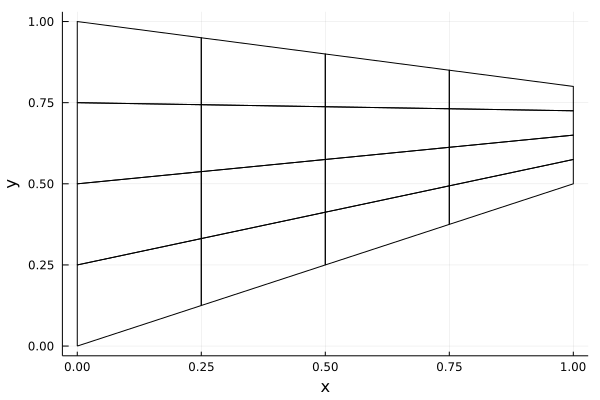

In [43]:
# mesh can be "uniform", "nonuniform", "stretched" "random"
mesh = "nonuniform"
n = 4
p = plotmesh(mesh, n, n)
plot(p)
#plot(p,xlims=Plots.widen(0,1), ylims=Plots.widen(0,1), zlims=Plots.widen(0, 1), camera=(20,35))
xlabel!("x")
ylabel!("y")

# Convergence Rate

In [19]:
N = 6
eu = zeros(N-1)
ep = zeros(N-1)
beta = zeros(N-1)
H = zeros(N-1)
# quadrature
Q1d = 4
# exact solution
uexact(x,y) = VelocityQuartic(x, y)
pexact(x,y) = PressureQuartic(x, y)
Forcing(x,y) = ForcingQuartic(x, y)
# refinement to plot convergence rate and inf-sup constant
for i=1:N-1

    nx = i+1
    ny = i+1

    Coord_Ns = GetCoordNodes(mesh, nx, ny)
    IENe, IENn = GetConnectivity(nx, ny)
    ID = GetID(nx, ny)
    LM = GetLM(ID, IENe)
    M, B, F1 = Assembly(Coord_Ns, LM, IENn, Q1d, Forcing)
    T = GetGlobalTraction(nx, ny, Coord_Ns, Q1d, "all", pexact)
    F = F1 - T
    uh, ph = GetFESol(M, B, F)
    
    ue = GetExactU(Coord_Ns, LM, IENn, uexact)
    pe = GetExactP(Coord_Ns, IENn, pexact)
    
    eu[i] = norm(ue - uh) / norm(ue)
    ep[i] = norm(pe - ph) / norm(pe)
    h = Gethsz(Coord_Ns, IENn)
    H[i] = h
end


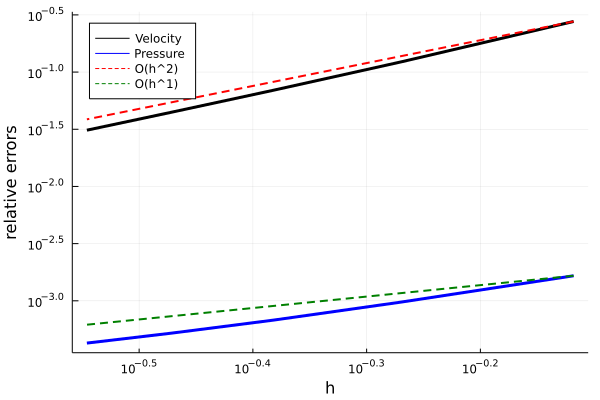

In [44]:
H2u = eu[1]*(H/H[1]).^2
H2p = ep[1]*(H/H[1]).^1
plot(H, eu, xaxis=:log, yaxis=:log, lw = 3, linestyles = :solid, color="black", label = "Velocity")
plot!(H, ep, xaxis=:log, yaxis=:log, lw = 3, linestyles = :solid, color= "blue", label = "Pressure")
plot!(H, H2u, xaxis=:log, yaxis=:log, lw = 2, linestyles = :dash, color="red", label = "O(h^2)")
plot!(H, H2p, xaxis=:log, yaxis=:log, lw = 2, linestyles = :dash, color="green",label = "O(h^1)" ,legend=:topleft)
xlabel!("h")
ylabel!("relative errors")